#  Objective 3: Optimize Product Recommendation Strategies

This notebook implements the third objective of the dissertation:
**To refine online retail recommendation systems using insights from Market Basket Analysis (MBA).**

By leveraging the FP-Growth algorithm, we will identify products frequently bought together and use these insights to enhance a rule-based recommendation system. The final goal is to improve personalized product suggestions for users and assess its practical impact.

---


#  Recommendation Optimization using Market Basket Analysis

This notebook addresses the third objective of the dissertation: **to optimize product recommendation strategies** by leveraging insights gained from frequent itemset mining. Using the FP-Growth algorithm, we aim to identify product bundles and association rules that help improve personalized recommendations.

---

###  Business & Analytical Questions:

- **1**: How can we prepare transaction data for recommendation modeling?  
  _Prepares purchase records to be transformed into transactions per user/order for pattern mining._

- **2**: What frequent product combinations does FP-Growth reveal?  
  _Discovers product groups often bought together, forming the foundation for recommendations._

- **3**: What strong association rules can inform recommendations?  
  _Helps derive if-then suggestions (e.g., "If A is bought, recommend B")._

- **4**: How can we build a rule-based product recommender using MBA results?  
  _Uses discovered patterns to generate a basic product recommendation engine._

- **5**: What are the benefits and limitations of the rule-based approach?  
  _Evaluates whether this method scales and suits personalization needs._

---


##  Step 1: Data Preparation

### 5.1 How can we prepare transaction data for recommendation modeling?

In [1]:
import pandas as pd
from scipy.sparse import csr_matrix
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

In [2]:
# File paths (use raw strings or double backslashes)
base_path = r"E:\Semester 2\Research Proposal\Msc Dissertation\Insta Cart data Set"

# Load CSV files
orders_df = pd.read_csv(f"{base_path}\\orders.csv", usecols=['order_id', 'user_id', 'eval_set'])
orders_df = orders_df[orders_df['eval_set'] == 'prior']  # Use only historical orders
products_df = pd.read_csv(f"{base_path}\\products.csv",usecols=['product_id', 'product_name'])

order_products_df = pd.read_csv(f"{base_path}\\order_products__prior.csv")


merged_df = order_products_df.merge(products_df, on="product_id")
merged_df = merged_df.merge(orders_df[['order_id', 'user_id']], on="order_id")

##  Step 2: Apply FP-Growth for MBA Insights

### 5.2 What frequent product combinations does FP-Growth reveal?

In [3]:

sample_orders = merged_df['order_id'].drop_duplicates().sample(50000, random_state=42)
filtered = merged_df[merged_df['order_id'].isin(sample_orders)]

top_products = filtered['product_name'].value_counts().head(1000).index
filtered = filtered[filtered['product_name'].isin(top_products)]

In [ ]:
#To get Next 70000 orders and top 1000 products
#  Get next 70,000 orders (after top 50,000) 

#  Get all unique order IDs and convert to Index
all_orders = merged_df['order_id'].drop_duplicates().sort_values().reset_index(drop=True)
used_orders = sample_orders  # sample_orders from the previous batch

# Convert to Index for difference operation
remaining_orders = pd.Index(all_orders).difference(pd.Index(used_orders))

# Select next 70,000 orders from what's left
sample_orders = remaining_orders[:70000]

# Filter to the next 50k orders
filtered = merged_df[merged_df['order_id'].isin(sample_orders)]

# #  Get next 1,000 most frequent products (after top 1,000)
# all_product_counts = merged_df['product_name'].value_counts()
# top_products = all_product_counts.iloc[1000:2000].index

top_products = filtered['product_name'].value_counts().head(1000).index


#  Filter only those products
filtered = filtered[filtered['product_name'].isin(top_products)]

print(f"Transactions: {filtered['order_id'].nunique()} | Products: {filtered['product_name'].nunique()}")
filtered.head(20)

Transactions: 64559 | Products: 1000


,order_id,product_id,add_to_cart_order,reordered,product_name,user_id
0,2,33120,1,1,Organic Egg Whites,202279
1,2,28985,2,1,Michigan Organic Kale,202279
2,2,9327,3,0,Garlic Powder,202279
5,2,17794,6,1,Carrots,202279
9,26,33120,5,0,Organic Egg Whites,153404
10,26,21903,6,0,Organic Baby Spinach,153404
11,26,24852,2,1,Banana,153404
12,26,47766,8,1,Organic Avocado,153404
13,26,35951,1,0,Organic Unsweetened Almond Milk,153404
14,26,46206,3,0,Red Grapefruit,153404


### 5.3 What strong association rules can inform recommendations?

In [5]:

transactions = filtered.groupby("order_id")["product_name"].apply(list).tolist()

te = TransactionEncoder()
encoded_sparse = te.fit(transactions).transform(transactions, sparse=True)

### 5.4 How can we build a rule-based product recommender using MBA results?

In [6]:
# Convert to DataFrame

df_encoded = pd.DataFrame.sparse.from_spmatrix(
    csr_matrix(encoded_sparse.astype(int)),  # use int or bool
    columns=te.columns_
)

df_encoded = df_encoded.astype(pd.SparseDtype("bool", fill_value=False))

# Preview shape
print("Encoded shape:", df_encoded.shape)
df_encoded.head()

Encoded shape: (64559, 1000)


,0% Greek Strained Yogurt,1% Low Fat Milk,1% Lowfat Milk,100 Calorie Per Bag Popcorn,100% Grated Parmesan Cheese,100% Lactose Free Fat Free Milk,100% Natural Spring Water,100% Pure Apple Juice,100% Pure Pumpkin,100% Raw Coconut Water,...,YoKids Squeeze! Organic Strawberry Flavor Yogurt,"YoKids Squeezers Organic Low-Fat Yogurt, Strawberry",YoKids Strawberry Banana/Strawberry Yogurt,Yobaby Organic Plain Yogurt,"Yogurt, Lowfat, Strawberry","Yogurt, Strained Low-Fat, Coconut",Yotoddler Organic Pear Spinach Mango Yogurt,Yukon Gold Potatoes 5lb Bag,ZBar Organic Chocolate Brownie Energy Snack,Zero Calorie Cola
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


##  Step 3: Rule-Based Recommendation Engine

### 5.5 What are the benefits and limitations of the rule-based approach?

In [7]:
from mlxtend.frequent_patterns import fpgrowth, association_rules

frequent_itemsets = fpgrowth(df_encoded, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.02)
rules = rules.sort_values(by='lift', ascending=False)

rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(100)

,antecedents,consequents,support,confidence,lift
17,(Organic Raspberries),(Organic Strawberries),0.010533,0.227121,2.556258
16,(Organic Strawberries),(Organic Raspberries),0.010533,0.118550,2.556258
15,(Organic Raspberries),(Bag of Organic Bananas),0.013925,0.300267,2.316834
14,(Bag of Organic Bananas),(Organic Raspberries),0.013925,0.107446,2.316834
32,(Banana),(Organic Fuji Apple),0.011091,0.068536,2.266723
33,(Organic Fuji Apple),(Banana),0.011091,0.366803,2.266723
6,(Bag of Organic Bananas),(Organic Hass Avocado),0.021143,0.163141,2.264018
7,(Organic Hass Avocado),(Bag of Organic Bananas),0.021143,0.293422,2.264018
13,(Organic Hass Avocado),(Organic Strawberries),0.013646,0.189381,2.131493
12,(Organic Strawberries),(Organic Hass Avocado),0.013646,0.153591,2.131493


In [8]:
# Display top 10 most confident rules
top_rules = rules.sort_values(by='confidence', ascending=False).head(100)

for _, row in top_rules.iterrows():
    ant = ', '.join(row['antecedents'])
    con = ', '.join(row['consequents'])
    print(f"🛒 If a customer buys [{ant}], also suggest [{con}] (Confidence: {row['confidence']:.2f}, Lift: {row['lift']:.2f})")

🛒 If a customer buys [Organic Fuji Apple], also suggest [Banana] (Confidence: 0.37, Lift: 2.27)
🛒 If a customer buys [Cucumber Kirby], also suggest [Banana] (Confidence: 0.33, Lift: 2.05)
🛒 If a customer buys [Organic Avocado], also suggest [Banana] (Confidence: 0.31, Lift: 1.89)
🛒 If a customer buys [Organic Raspberries], also suggest [Bag of Organic Bananas] (Confidence: 0.30, Lift: 2.32)
🛒 If a customer buys [Organic Hass Avocado], also suggest [Bag of Organic Bananas] (Confidence: 0.29, Lift: 2.26)
🛒 If a customer buys [Strawberries], also suggest [Banana] (Confidence: 0.29, Lift: 1.79)
🛒 If a customer buys [Large Lemon], also suggest [Banana] (Confidence: 0.27, Lift: 1.67)
🛒 If a customer buys [Organic Raspberries], also suggest [Organic Strawberries] (Confidence: 0.23, Lift: 2.56)
🛒 If a customer buys [Organic Strawberries], also suggest [Bag of Organic Bananas] (Confidence: 0.23, Lift: 1.75)
🛒 If a customer buys [Limes], also suggest [Banana] (Confidence: 0.23, Lift: 1.40)
🛒 If 

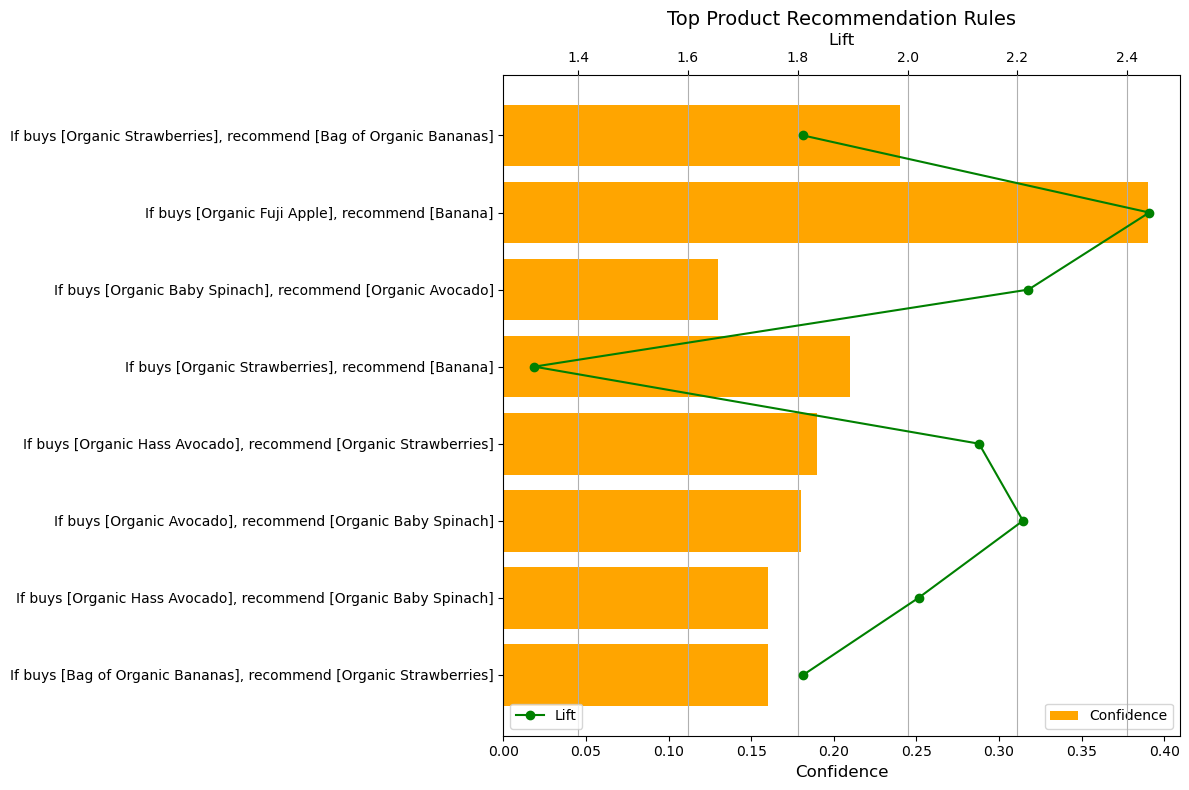

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from the rules
rules_data = [
    ("Organic Strawberries", "Bag of Organic Bananas", 0.24, 1.81),
    ("Organic Fuji Apple", "Banana", 0.39, 2.44),
    ("Organic Baby Spinach", "Organic Avocado", 0.13, 2.22),
    ("Organic Strawberries", "Banana", 0.21, 1.32),
    ("Organic Hass Avocado", "Organic Strawberries", 0.19, 2.13),
    ("Organic Avocado", "Organic Baby Spinach", 0.18, 2.21),
    ("Organic Hass Avocado", "Organic Baby Spinach", 0.16, 2.02),
    ("Bag of Organic Bananas", "Organic Strawberries", 0.16, 1.81),
]

df_rules = pd.DataFrame(rules_data, columns=["Antecedent", "Consequent", "Confidence", "Lift"])

# Prepare labels
labels = [f"If buys [{a}], recommend [{c}]" for a, c in zip(df_rules["Antecedent"], df_rules["Consequent"])]

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar for Confidence
bars = ax1.barh(labels, df_rules["Confidence"], color='orange', label='Confidence')
ax1.set_xlabel('Confidence', fontsize=12)
ax1.set_title('Top Product Recommendation Rules', fontsize=14)
ax1.invert_yaxis()

# Twin axis for Lift
ax2 = ax1.twiny()
ax2.plot(df_rules["Lift"], labels, 'go-', label='Lift')
ax2.set_xlabel('Lift', fontsize=12)

# Legend and layout
ax1.legend(loc='lower right')
ax2.legend(loc='lower left')
plt.tight_layout()
plt.grid(True)
plt.box(False)
plt.show()

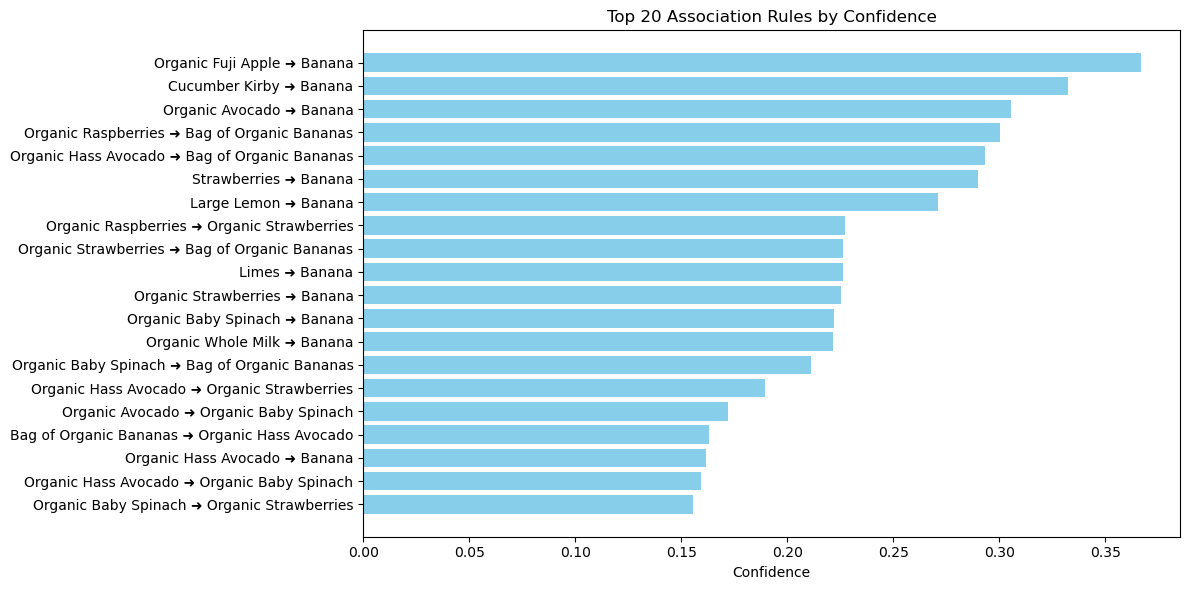

In [10]:
import matplotlib.pyplot as plt

# Prepare for plotting
top_rules = rules.sort_values(by='confidence', ascending=False).head(20).copy()
top_rules['rule'] = top_rules.apply(lambda row: f"{', '.join(row['antecedents'])} ➜ {', '.join(row['consequents'])}", axis=1)

# Plot
plt.figure(figsize=(12,6))
plt.barh(top_rules['rule'], top_rules['confidence'], color='skyblue')
plt.xlabel("Confidence")
plt.title("Top 20 Association Rules by Confidence")
plt.gca().invert_yaxis()  # Most confident rule on top
plt.tight_layout()
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10888\206823985.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(top_rules['rule'], rotation=45, ha='right')


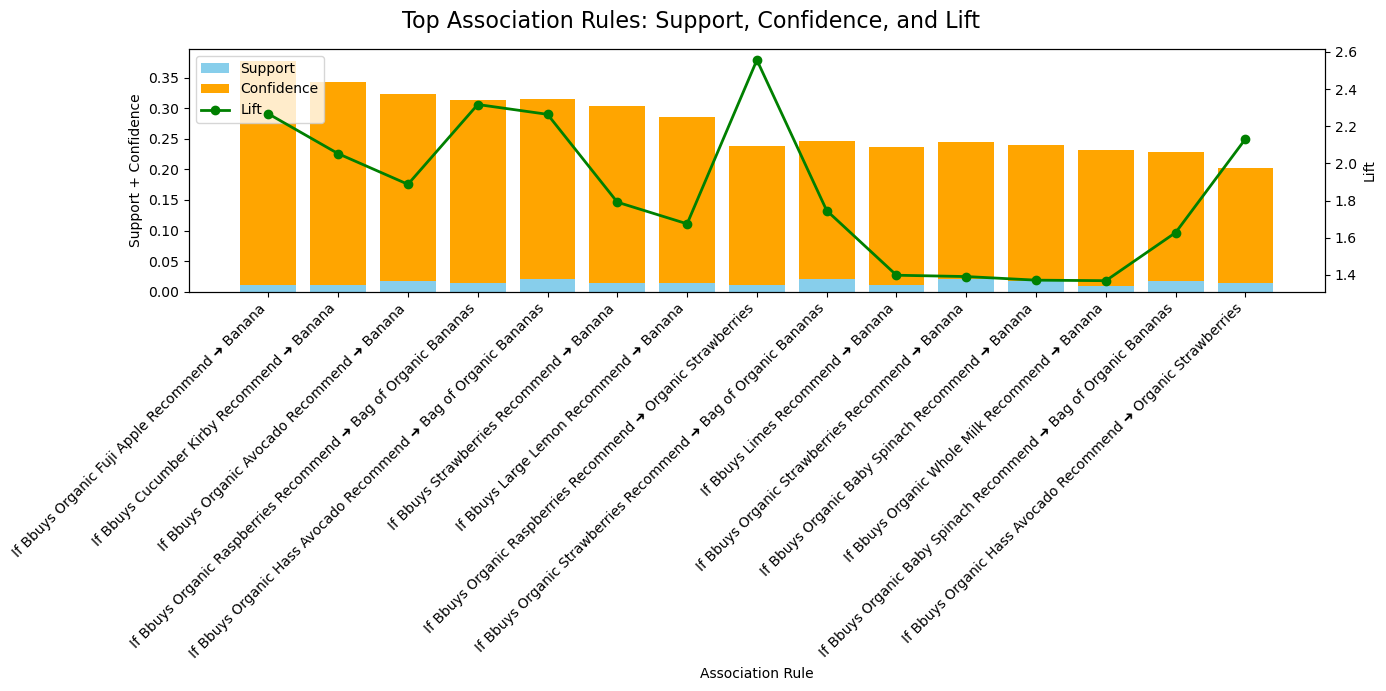

In [11]:
import matplotlib.pyplot as plt

# Select top N rules by confidence
top_rules = rules.sort_values(by='confidence', ascending=False).head(15).copy()

# Create a readable label for each rule
top_rules['rule'] = top_rules.apply(lambda row: f"If Bbuys {', '.join(row['antecedents'])} Recommend ➜ {', '.join(row['consequents'])}", axis=1)




labels = [f"If buys [{a}], recommend [{c}]" for a, c in zip(df_rules["Antecedent"], df_rules["Consequent"])]


# Plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar chart for support and confidence
ax1.bar(top_rules['rule'], top_rules['support'], label='Support', color='skyblue')
ax1.bar(top_rules['rule'], top_rules['confidence'], bottom=top_rules['support'], label='Confidence', color='orange')

# Twin axis for lift
ax2 = ax1.twinx()
ax2.plot(top_rules['rule'], top_rules['lift'], label='Lift', color='green', marker='o', linewidth=2)

# Aesthetics
ax1.set_ylabel('Support + Confidence')
ax2.set_ylabel('Lift')
ax1.set_xlabel('Association Rule')
ax1.set_xticklabels(top_rules['rule'], rotation=45, ha='right')
fig.suptitle('Top Association Rules: Support, Confidence, and Lift', fontsize=16)

# Legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()

##  Step 4: Evaluation Planning 

A/B testing will be used to compare two groups:

- **Control Group:** Receives recommendations from standard collaborative filtering
- **Test Group:** Receives enhanced recommendations using collaborative filtering + MBA rules

Metrics:
- Click-through rate (CTR)
- Conversion rate (purchases made from recommendations)
- Average basket size
- Customer satisfaction score (optional survey or rating)

Statistical tests such as t-tests or Chi-squared will be used to determine significance of improvement.


##  Step 6: Feedback & Optimization

After testing, feedback mechanisms (explicit or implicit) will refine the recommendation system.

Refinements may include:
- Adjusting confidence/lift thresholds
- Re-training models with updated behavior
- Personalizing rule weights per user segment
